# Project: Analysis of Bank Stocks from US, Japan, and Hong Kong

## Introduction: 

* Background: 

* Aim: 


In [1]:
# Requirements 
!pip install yfinance 

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
import time

driver_path = "/usr/local/bin/chromedriver"

# Chrome Driver setup 
service = Service(driver_path)
options = Options()
options.add_argument("--start-maximized")
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 Chrome/120 Safari/537.36")

In [110]:
#jan2024-jul2024
url_jp_1 = "https://www.google.com/search?q=Japan+interest+rate&sca_esv=cab469c6dae8b008&tbs=sbd:1,cdr:1,cd_min:1/1/2024,cd_max:7/31/2024&tbm=nws"
#aug2024-feb25
url_jp_2 = "https://www.google.com/search?q=Japan+interest+rate&sca_esv=cab469c6dae8b008&tbas=0&tbs=cdr:1,cd_min:8/1/2024,cd_max:2/28/2025,sbd:1&tbm=nws"
#mar25-now 
url_jp_3 = "https://www.google.com/search?q=Japan+interest+rate&sca_esv=cab469c6dae8b008&tbas=0&tbs=cdr:1,cd_min:3/1/2025,sbd:1&tbm=nws"


urls_jp = [url_jp_1, url_jp_2, url_jp_3]

In [111]:
jp_news_data = []

for link in urls_jp: 
    driver = webdriver.Chrome(service=service, options=options)
    driver.get(link)
    time.sleep(10)

    while True:
        # Find the news items (using CSS selectors, adjust as needed)
        news_items = driver.find_elements(By.CSS_SELECTOR, "div.SoaBEf") #div.SoaBEf
        # Extract data from each item
        for item in news_items:
            try:
                # Extract headline
                headline = item.find_element(By.CSS_SELECTOR, "div.n0jPhd.ynAwRc.MBeuO.nDgy9d").text #n0jPhd ynAwRc MBeuO nDgy9d

                # Extract source (adjust selector if needed)
                source = item.find_element(By.CSS_SELECTOR, "div.MgUUmf.NUnG9d").text

                # Extract snippet (adjust selector if needed)
                intro = item.find_element(By.CSS_SELECTOR, "div.GI74Re.nDgy9d").text

                # Extract date 
                date = item.find_element(By.CSS_SELECTOR, "div.OSrXXb.rbYSKb.LfVVr").text #OSrXXb rbYSKb LfVVr

                jp_news_data.append({
                    "headline": headline,
                    "source": source,
                    "intro": intro,
                    "date": date
                })
            except Exception as e:
                print(f"Error extracting data: {e}")
        try:
            next_button = driver.find_element(By.ID, "pnnext") 
            # next_button = driver.find_element(By.CSS_SELECTOR, "td.d6cvqb.BBwThe a")
            next_button.click()
            time.sleep(5)
        except Exception as e:
            print(f"Error: {e}")
            break

    driver.quit()

Error: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="pnnext"]"}
  (Session info: chrome=138.0.7204.169); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
0   chromedriver                        0x000000010fe39728 chromedriver + 5891880
1   chromedriver                        0x000000010fe30e7a chromedriver + 5856890
2   chromedriver                        0x000000010f901400 chromedriver + 418816
3   chromedriver                        0x000000010f95322b chromedriver + 754219
4   chromedriver                        0x000000010f953441 chromedriver + 754753
5   chromedriver                        0x000000010f9a3cd4 chromedriver + 1084628
6   chromedriver                        0x000000010f97950d chromedriver + 910605
7   chromedriver                        0x000000010f9a1073 chromedriver + 1073267
8   chromedriver                      

In [112]:
# 5. Converting the results into a DataFrame 
jp_news_df = pd.DataFrame(jp_news_data)

# 6. Saving into .csv
jp_news_df.to_csv("jp_news.csv", index=False)

In [113]:
len(jp_news_df)

756

In [114]:
jp_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  756 non-null    object
 1   source    756 non-null    object
 2   intro     756 non-null    object
 3   date      756 non-null    object
dtypes: object(4)
memory usage: 23.8+ KB


In [115]:
from datetime import datetime, timedelta
import pandas as pd
import re

# Current time 
now = datetime.now() 

def parse_relative_time(date_string): 
    date_string = date_string.lower().strip()
    if date_string == 'just now': 
        return now 
    match = re.match(r'(\d+)\s+(second|minute|hour|day|week|month|year)s?\s+ago', date_string)
    if match: 
        value, unit = int(match.group(1)), match.group(2)
        # simply assume 1 month = 30 days, 1 year = 365 days
        multiplier = {
            'second': timedelta(seconds=value),
            'minute': timedelta(minutes=value),
            'hour': timedelta(hours=value),
            'day': timedelta(days=value),
            'week': timedelta(weeks=value),
            'month': timedelta(days=30*value),
            'year': timedelta(days=365*value)
        }
        return now - multiplier[unit]
    return pd.NaT # for inconvertable scenarios 

jp_news_df['datetime'] = jp_news_df['date'].apply(parse_relative_time).dt.date
jp_news_df

,headline,source,intro,date,datetime
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,NaT
1,Bank of Japan delivers one-two punch few were ...,The Japan Times,The Bank of Japan raised rates Wednesday in a ...,31 Jul 2024,NaT
2,BOJ to weigh rate hike to 0.25% at Wednesday p...,Nikkei Asia,TOKYO -- The Bank of Japan is considering rais...,31 Jul 2024,NaT
3,Japan’s Ultra-Low Mortgages to See First Incre...,Bloomberg,The Bank of Japan's second interest-rate hike ...,31 Jul 2024,NaT
4,Bank of Japan’s rate hike hits highest since 2...,CryptoRank,"Quick Take As reported by Trading Economics, t...",31 Jul 2024,NaT
...,...,...,...,...,...
751,The world’s lowest interest rate no longer bel...,MarketWatch,Referenced Symbols ... The world's lowest inte...,20 Mar 2025,NaT
752,Bank of Japan leaves interest rates unchanged ...,Asia News Network,The Bank of Japan decided to leave policy inte...,20 Mar 2025,NaT
753,Bank of Japan has to be careful in choosing wh...,YouTube\n · CNBC International Live,"Sayuri Shirai, professor at Keio University an...",19 Mar 2025,NaT
754,"Crypto Climbs as Bank of Japan Holds Rates, Fo...",CCN.com,The Bank of Japan (BoJ) kept its key interest ...,19 Mar 2025,NaT


Realized that google only shows up to page 30 (with max 10 articles per page) = 300 in total 

so I've decided to scrap once more from 
Aug 26th 2024 to Jan 1st 2024. 

For dates that are formatted in # days/months/years ago -> it's now showing in the '%Y-%m-%d' format

However, the dates in the format of '%d %b %Y' still need to be converted 

In [123]:
#temporarily saving the NaT rows into a new dataframe 
tmp_df = jp_news_df.loc[jp_news_df['datetime'].isna()]
tmp_df.head()

,headline,source,intro,date,datetime
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,NaT
1,Bank of Japan delivers one-two punch few were ...,The Japan Times,The Bank of Japan raised rates Wednesday in a ...,31 Jul 2024,NaT
2,BOJ to weigh rate hike to 0.25% at Wednesday p...,Nikkei Asia,TOKYO -- The Bank of Japan is considering rais...,31 Jul 2024,NaT
3,Japan’s Ultra-Low Mortgages to See First Incre...,Bloomberg,The Bank of Japan's second interest-rate hike ...,31 Jul 2024,NaT
4,Bank of Japan’s rate hike hits highest since 2...,CryptoRank,"Quick Take As reported by Trading Economics, t...",31 Jul 2024,NaT


In [124]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 0 to 755
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  659 non-null    object
 1   source    659 non-null    object
 2   intro     659 non-null    object
 3   date      659 non-null    object
 4   datetime  0 non-null      object
dtypes: object(5)
memory usage: 30.9+ KB


In [125]:
tmp_df['date']

0      31 Jul 2024
1      31 Jul 2024
2      31 Jul 2024
3      31 Jul 2024
4      31 Jul 2024
          ...     
751    20 Mar 2025
752    20 Mar 2025
753    19 Mar 2025
754    19 Mar 2025
755    19 Mar 2025
Name: date, Length: 659, dtype: object

In [ ]:
# attribute error since %b 'Sept' X -- 'Sep' O

tmp_df['date'] = tmp_df['date'].replace('Sept', 'Sep', regex=True)

/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_8120/3015187565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['date'] = tmp_df['date'].replace('Sept', 'Sep', regex=True)


In [127]:
# convert the date's dtype to datetime
tmp_df['date_parsed'] = pd.to_datetime(tmp_df['date'], format='%d %b %Y') 
tmp_df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 0 to 755
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   headline     659 non-null    object        
 1   source       659 non-null    object        
 2   intro        659 non-null    object        
 3   date         659 non-null    object        
 4   datetime     0 non-null      object        
 5   date_parsed  659 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 36.0+ KB


/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_8120/911281988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['date_parsed'] = pd.to_datetime(tmp_df['date'], format='%d %b %Y')


newly created column 'date_parsed' is no longer 'object', it's 'datetime' Dtype

In [128]:
# convert to '%Y-%m-%d' in the 'datetime' column
tmp_df['datetime'] = tmp_df['date_parsed'].dt.strftime('%Y-%m-%d')
tmp_df.head()

/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_8120/3115136998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['datetime'] = tmp_df['date_parsed'].dt.strftime('%Y-%m-%d')


,headline,source,intro,date,datetime,date_parsed
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,2024-07-31,2024-07-31
1,Bank of Japan delivers one-two punch few were ...,The Japan Times,The Bank of Japan raised rates Wednesday in a ...,31 Jul 2024,2024-07-31,2024-07-31
2,BOJ to weigh rate hike to 0.25% at Wednesday p...,Nikkei Asia,TOKYO -- The Bank of Japan is considering rais...,31 Jul 2024,2024-07-31,2024-07-31
3,Japan’s Ultra-Low Mortgages to See First Incre...,Bloomberg,The Bank of Japan's second interest-rate hike ...,31 Jul 2024,2024-07-31,2024-07-31
4,Bank of Japan’s rate hike hits highest since 2...,CryptoRank,"Quick Take As reported by Trading Economics, t...",31 Jul 2024,2024-07-31,2024-07-31


In [129]:
# replace NaT cells in the original dataframe 
jp_news_df.loc[jp_news_df['datetime'].isna(), 'datetime'] = tmp_df['datetime']
jp_news_df

,headline,source,intro,date,datetime
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,2024-07-31
1,Bank of Japan delivers one-two punch few were ...,The Japan Times,The Bank of Japan raised rates Wednesday in a ...,31 Jul 2024,2024-07-31
2,BOJ to weigh rate hike to 0.25% at Wednesday p...,Nikkei Asia,TOKYO -- The Bank of Japan is considering rais...,31 Jul 2024,2024-07-31
3,Japan’s Ultra-Low Mortgages to See First Incre...,Bloomberg,The Bank of Japan's second interest-rate hike ...,31 Jul 2024,2024-07-31
4,Bank of Japan’s rate hike hits highest since 2...,CryptoRank,"Quick Take As reported by Trading Economics, t...",31 Jul 2024,2024-07-31
...,...,...,...,...,...
751,The world’s lowest interest rate no longer bel...,MarketWatch,Referenced Symbols ... The world's lowest inte...,20 Mar 2025,2025-03-20
752,Bank of Japan leaves interest rates unchanged ...,Asia News Network,The Bank of Japan decided to leave policy inte...,20 Mar 2025,2025-03-20
753,Bank of Japan has to be careful in choosing wh...,YouTube\n · CNBC International Live,"Sayuri Shirai, professor at Keio University an...",19 Mar 2025,2025-03-19
754,"Crypto Climbs as Bank of Japan Holds Rates, Fo...",CCN.com,The Bank of Japan (BoJ) kept its key interest ...,19 Mar 2025,2025-03-19


As the tmp_df's the NaT rows got the same indices from the original jp_news_df, I was able to replace the NaT rows with the above command

We want to group the news articles by the 'month' published so let's strip the date into '%Y-%m' format

In [130]:
# convert datetime's Dtype 
jp_news_df['datetime'] = pd.to_datetime(jp_news_df['datetime'], format='%Y-%m-%d')

In [131]:
# Create a new column called 'month' that shows each article's published month in '%Y-%m' format
jp_news_df['month'] = jp_news_df['datetime'].dt.strftime('%Y-%m')
jp_news_df.head()

,headline,source,intro,date,datetime,month
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,2024-07-31,2024-07
1,Bank of Japan delivers one-two punch few were ...,The Japan Times,The Bank of Japan raised rates Wednesday in a ...,31 Jul 2024,2024-07-31,2024-07
2,BOJ to weigh rate hike to 0.25% at Wednesday p...,Nikkei Asia,TOKYO -- The Bank of Japan is considering rais...,31 Jul 2024,2024-07-31,2024-07
3,Japan’s Ultra-Low Mortgages to See First Incre...,Bloomberg,The Bank of Japan's second interest-rate hike ...,31 Jul 2024,2024-07-31,2024-07
4,Bank of Japan’s rate hike hits highest since 2...,CryptoRank,"Quick Take As reported by Trading Economics, t...",31 Jul 2024,2024-07-31,2024-07


### Merging headlines and intros -> 1 string per month

In [132]:
# create a new column to concatenate headlines and introductions into one string 
jp_news_df['full_content'] = jp_news_df['headline']+" "+jp_news_df['intro']+" "
jp_news_df.head()

,headline,source,intro,date,datetime,month,full_content
0,What the BOJ Rate Hike Tells Us About Japan's ...,YouTube\n · Bloomberg Podcasts,The Bank of Japan raised its benchmark interes...,31 Jul 2024,2024-07-31,2024-07,What the BOJ Rate Hike Tells Us About Japan's ...
1,Bank of Japan delivers one-two punch few were ...,The Japan Times,The Bank of Japan raised rates Wednesday in a ...,31 Jul 2024,2024-07-31,2024-07,Bank of Japan delivers one-two punch few were ...
2,BOJ to weigh rate hike to 0.25% at Wednesday p...,Nikkei Asia,TOKYO -- The Bank of Japan is considering rais...,31 Jul 2024,2024-07-31,2024-07,BOJ to weigh rate hike to 0.25% at Wednesday p...
3,Japan’s Ultra-Low Mortgages to See First Incre...,Bloomberg,The Bank of Japan's second interest-rate hike ...,31 Jul 2024,2024-07-31,2024-07,Japan’s Ultra-Low Mortgages to See First Incre...
4,Bank of Japan’s rate hike hits highest since 2...,CryptoRank,"Quick Take As reported by Trading Economics, t...",31 Jul 2024,2024-07-31,2024-07,Bank of Japan’s rate hike hits highest since 2...


In [133]:
# group all 'full_content' by months 
monthly_content = jp_news_df.groupby('month')['full_content'].sum()
monthly_content

month
2024-01    'Golden opportunity': BOJ signals rate hike ah...
2024-02    Why and How Poverty in Japan is Concealed Mode...
2024-03    How interest rate actions by Japan, US & EU co...
2024-04    Why Japan’s currency is cratering right now, e...
2024-05    Yen's relentless slide revives Japan's interes...
2024-06    Japan’s Solid Business Sentiment Keeps July Ra...
2024-07    What the BOJ Rate Hike Tells Us About Japan's ...
2024-08    Japan interest rates, defense buildup push bud...
2024-09    Here’s why Japan’s stocks are plunging after S...
2024-10    The shorter the better: BoJ rate rise changes ...
2024-11    Japan wage trends key to potential rate hikes,...
2024-12    Bank of Japan risks over $12bn annual loss at ...
2025-01    Bank of Japan could face capital losses if int...
2025-02    Odds of early rate rise increase as inflation ...
2025-03    The world’s lowest interest rate no longer bel...
2025-04    Bank of Japan Keeps Rates Unchanged as Tariffs...
2025-05    Core in

In [134]:
# convert into a dataframe 
monthly_content_df = monthly_content.to_frame()
monthly_content_df

,full_content
month,
2024-01,'Golden opportunity': BOJ signals rate hike ah...
2024-02,Why and How Poverty in Japan is Concealed Mode...
2024-03,"How interest rate actions by Japan, US & EU co..."
2024-04,"Why Japan’s currency is cratering right now, e..."
2024-05,Yen's relentless slide revives Japan's interes...
2024-06,Japan’s Solid Business Sentiment Keeps July Ra...
2024-07,What the BOJ Rate Hike Tells Us About Japan's ...
2024-08,"Japan interest rates, defense buildup push bud..."
2024-09,Here’s why Japan’s stocks are plunging after S...


In [135]:
monthly_content_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 2024-01 to 2025-07
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   full_content  19 non-null     object
dtypes: object(1)
memory usage: 860.0+ bytes


### English Morphemes Analysis 
To identify key words related to interest rate

In [136]:
import spacy 

nlp = spacy.load("en_core_web_sm")

target_pos = ["VERB"]

def extract_morphemes(text, target_pos):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.pos_ in target_pos and not token.is_stop]
    # for token in doc: 
    #     if token.pos_ in target_pos and not token.is_stop: 
    #         return token.lemma_

In [137]:
jp_news_verbs = []

for index, row in monthly_content_df.iterrows(): 
    for column_name, value in row.items():
        monthly_verb = extract_morphemes(value, target_pos)
        jp_news_verbs.append({
            index: monthly_verb
        })

print(jp_news_verbs)

[{'2024-01': ['ramp', 'move', 'raise', 'mark', 'float', 'adopt', 'lose', 'say', 'exit', 'begin', 'lower', 'result', 'make', 'stimulate', 'get', 'start', 'apply', 'see', 'grow', 'swell', 'charge', 'charge', 'keep', 'guess', 'pave', 'put', 'expect', 'struggle', 'gain', 'contract', 'erode', 'roar', 'lead', 'set', 'poise', 'tighten', 'spur', 'announce', 'say', 'raise', 'grow', 'help', 'fulfill', 'define', 'experience', 'implement', 'enjoy']}, {'2024-02': ['conceal', 'attribute', 'cause', 'heighten', 'live', 'convince', 'normalize', 'hike', 'look', 'resist', 'turn', 'slip', 'juggle', 'support', 'expect', 'exit', 'limit', 'alleviate', 'plan', 'zombie', 'threaten', 'rise', 'lead', 'lose', 'discourage', 'invest']}, {'2024-03': ['affect', 'affect', 'impact', 'announce', 'set', 'expect', 'spare', 'expect', 'impact', 'decide', 'halt', 'end', 'end', 'raise', 'signal', 'raise', 'pursue', 'affect', 'fall', 'make', 'implement', 'raise', 'lift', 'end', 'end', 'stimulate', 'rise', 'include', 'hike', 'f

In [139]:
from collections import Counter

jp_top_10 = []

for dictionary_item in jp_news_verbs:
    # Iterate through the key-value pairs of the current dictionary
    for key, value in dictionary_item.items():
        jp_verb_count = Counter(value)
        jp_verb_top_10 = jp_verb_count.most_common(10)
        jp_top_10.append({
            key: jp_verb_top_10
        })
        # print(f"{key}: {value}")
    # print("---") # Separator for clarity

jp_top_10

[{'2024-01': [('raise', 2),
   ('say', 2),
   ('grow', 2),
   ('charge', 2),
   ('ramp', 1),
   ('move', 1),
   ('mark', 1),
   ('float', 1),
   ('adopt', 1),
   ('lose', 1)]},
 {'2024-02': [('conceal', 1),
   ('attribute', 1),
   ('cause', 1),
   ('heighten', 1),
   ('live', 1),
   ('convince', 1),
   ('normalize', 1),
   ('hike', 1),
   ('look', 1),
   ('resist', 1)]},
 {'2024-03': [('end', 73),
   ('raise', 38),
   ('scrap', 10),
   ('expect', 8),
   ('make', 8),
   ('decide', 7),
   ('follow', 7),
   ('rise', 5),
   ('mean', 5),
   ('impact', 4)]},
 {'2024-04': [('raise', 7),
   ('rise', 4),
   ('fall', 4),
   ('mean', 3),
   ('spend', 3),
   ('maintain', 3),
   ('take', 3),
   ('lift', 3),
   ('sell', 3),
   ('compare', 2)]},
 {'2024-05': [('raise', 6),
   ('rise', 5),
   ('slow', 3),
   ('plan', 2),
   ('change', 2),
   ('remain', 2),
   ('come', 2),
   ('hit', 2),
   ('escalate', 2),
   ('face', 2)]},
 {'2024-06': [('rise', 7),
   ('reduce', 6),
   ('leave', 4),
   ('consider', 

In [140]:
stop_word = ['tell', 'say', 'expect', 'face', 'end', 'set', 'show', 'see', 'announce', 'decide', 'take', 'discuss', 'hit', 'assess', 'push', 'give', 'leave', 'warn', 'set', 'maintain', 'initiate', 'relieve', 'offer', 'suggest', ]

In [141]:
# new list without stop words
new_jp_word_list = []
for dictionary_item in jp_news_verbs: 
    for key, value in dictionary_item.items():
        new_list = []
        for word in value: 
            if word not in stop_word: 
                new_list.append(word)
        new_jp_word_list.append({
            key: new_list
        })

In [86]:
new_jp_word_list

[{'2024-07': ['raise',
   'unveil',
   'halve',
   'underscore',
   'normalize',
   'hike',
   'accord',
   'reduce',
   'raise',
   'ditch',
   'raise',
   'signal',
   'grow',
   'hike',
   'signal',
   'raise',
   'signal',
   'increase',
   'raise',
   'ditch']},
 {'2024-08': ['happen',
   'rebound',
   'expand',
   'annualize',
   'rebound',
   'bounce',
   'support',
   'expand',
   'annualize',
   'rebound',
   'encourage',
   'continue',
   'raise',
   'carry',
   'benefit',
   'argue',
   'remain',
   'compare',
   'pick',
   'drop',
   'sit',
   'dent',
   'underestimate',
   'threaten',
   '|',
   'raise',
   'address',
   'update',
   'dominate',
   'raise',
   'market',
   'raise',
   'carry',
   'exploit',
   'raise',
   'send',
   'explain',
   'unwind',
   'carry',
   'disrupt',
   'rise',
   'rebound',
   'make',
   'rebound',
   'inject',
   'borrow',
   'hike',
   'follow',
   'lead',
   'slump',
   'explain',
   'know',
   'crash',
   'slam',
   'surge',
   'trigger

In [142]:
# counting & finding frequency of most repeated words
new_jp_top_10 = []
for dictionary_item in new_jp_word_list:
    # Iterate through the key-value pairs of the current dictionary
    for key, value in dictionary_item.items():
        jp_verb_count = Counter(value)
        jp_verb_top_10 = jp_verb_count.most_common(10) # change to 5? 
        new_jp_top_10.append({
            key: jp_verb_top_10
        })

In [143]:
new_jp_top_10

[{'2024-01': [('raise', 2),
   ('grow', 2),
   ('charge', 2),
   ('ramp', 1),
   ('move', 1),
   ('mark', 1),
   ('float', 1),
   ('adopt', 1),
   ('lose', 1),
   ('exit', 1)]},
 {'2024-02': [('conceal', 1),
   ('attribute', 1),
   ('cause', 1),
   ('heighten', 1),
   ('live', 1),
   ('convince', 1),
   ('normalize', 1),
   ('hike', 1),
   ('look', 1),
   ('resist', 1)]},
 {'2024-03': [('raise', 38),
   ('scrap', 10),
   ('make', 8),
   ('follow', 7),
   ('rise', 5),
   ('mean', 5),
   ('impact', 4),
   ('fall', 4),
   ('lift', 4),
   ('hike', 4)]},
 {'2024-04': [('raise', 7),
   ('rise', 4),
   ('fall', 4),
   ('mean', 3),
   ('spend', 3),
   ('lift', 3),
   ('sell', 3),
   ('compare', 2),
   ('accelerate', 2),
   ('strengthen', 2)]},
 {'2024-05': [('raise', 6),
   ('rise', 5),
   ('slow', 3),
   ('plan', 2),
   ('change', 2),
   ('remain', 2),
   ('come', 2),
   ('escalate', 2),
   ('target', 2),
   ('revive', 1)]},
 {'2024-06': [('rise', 7),
   ('reduce', 6),
   ('consider', 4),
   

In [73]:
import yfinance as yf 

jp_tickers = ["8306.T", "8316.T", "5830.T", "8399.T", "5831.T"]
                #Mitsubishi UFJ 8306.T
                #Sumitomo 8316.T
                #Iyogin Holdings 5830.T
                #Bank of The Ryukyus 8399.T
                #Shizuoka Bank 5831.T

start_date = '2024-01-01'
end_date = '2025-07-24'

jp_stocks_df = yf.download(jp_tickers, start=start_date, end=end_date, interval="1d")["Close"]
# import yfinance as yf

# # 예: 애플(AAPL)의 주가 데이터를 2022년 1월 1일부터 2022년 12월 31일까지 가져오기
# ticker = 'AAPL'
# start_date = '2022-01-01'
# end_date = '2022-12-31'

# data = yf.download(ticker, start=start_date, end=end_date)

# print(data.head())
print(jp_stocks_df.head())

/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_8120/2900924346.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  jp_stocks_df = yf.download(jp_tickers, start=start_date, end=end_date, interval="1d")["Close"]
[*********************100%***********************]  5 of 5 completed

Ticker          5830.T       5831.T       8306.T       8316.T       8399.T
Date                                                                      
2024-01-04  907.472839  1154.618774  1167.334351  2212.784424  1050.605591
2024-01-05  929.077148  1178.732422  1198.780884  2270.164307  1068.686646
2024-01-09  929.077148  1174.004150  1200.210205  2258.117676  1066.783447
2024-01-10  930.606628  1169.276001  1200.686646  2258.435059  1060.121948
2024-01-11  941.982300  1197.645020  1220.698120  2294.257812  1074.396484


In [74]:
len(jp_stocks_df)

380

In [75]:
jp_stocks_df.head()

Ticker,5830.T,5831.T,8306.T,8316.T,8399.T
Date,,,,,
2024-01-04,907.472839,1154.618774,1167.334351,2212.784424,1050.605591
2024-01-05,929.077148,1178.732422,1198.780884,2270.164307,1068.686646
2024-01-09,929.077148,1174.004150,1200.210205,2258.117676,1066.783447
2024-01-10,930.606628,1169.276001,1200.686646,2258.435059,1060.121948
2024-01-11,941.982300,1197.645020,1220.698120,2294.257812,1074.396484


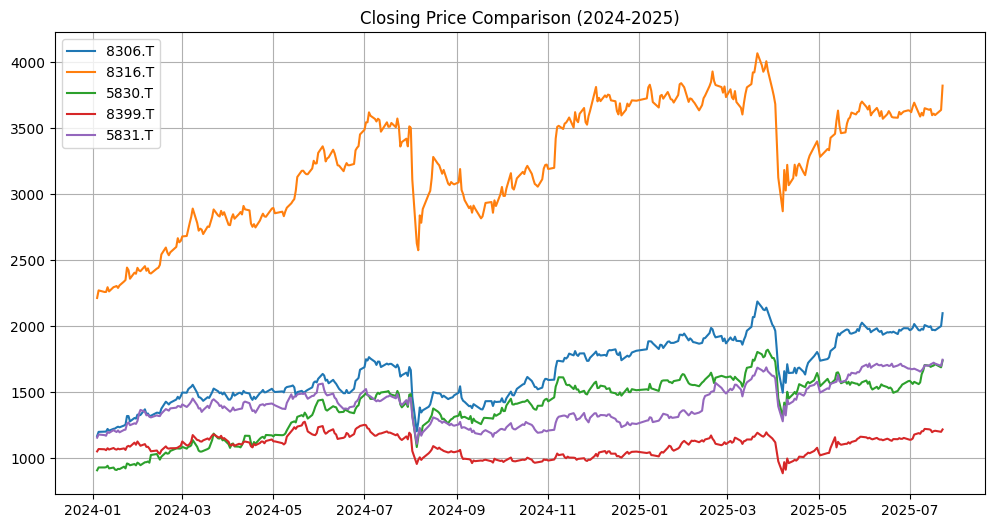

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for symbol in jp_tickers:
    plt.plot(jp_stocks_df[symbol], label=symbol)
plt.title("Closing Price Comparison (2024-2025)")
plt.legend()
plt.grid(True)
plt.show()

In [78]:
for symbol in jp_tickers:
    t = yf.Ticker(symbol)
    info = t.info
    price = info.get("currentPrice")
    eps = info.get("trailingEps")
    bps = info.get("bookValue")
    roe = info.get("returnOnEquity")

    per = price / eps if eps else None
    pbr = price / bps if bps else None

    print(f"[{symbol}]")
    print(f"PER: {per:.2f}")
    print(f"PBR: {pbr:.2f}")
    print(f"ROE: {roe:.2%}")
    print("-----------")

[8306.T]
PER: 13.53
PBR: 1.36
ROE: 6.71%
-----------
[8316.T]
PER: 13.21
PBR: 1.07
ROE: 3.15%
-----------
[5830.T]
PER: 10.11
PBR: 0.66
ROE: 6.48%
-----------
[8399.T]
PER: 9.03
PBR: 0.37
ROE: 4.07%
-----------
[5831.T]
PER: 12.99
PBR: 0.82
ROE: 6.30%
-----------
